# Mean bias correction

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '01:30:00'
cores = 8
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/fs38'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client#.restart()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.2:44613,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt

In [6]:
path_model = "/g/data/w42/dr6273/work/data/CMIP6/ACCESS-ESM1-5/historical/day/"
path_era = "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/"

In [7]:
def open_model(var):
    """
    Open ACCESS zarr collection
    """
    return xr.open_zarr(
        path_model + var + "/" + var + "_day_ACCESS-ESM1-5_historical_1950-2014_NEM.zarr",
        consolidated=True
    )

In [8]:
def open_era(var):
    """
    Open ERA5 data regridded to ACCESS grid
    """
    return xr.open_mfdataset(
        path_era + var + "_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
    )

### Variables

Temperature (2m)

In [ ]:
tas_model = open_model("tas").sel(time=slice("1959", "2014"))["tas"]

In [10]:
tas_era = open_era("2t").rename({"t2m": "tas"})["tas"]

Surface radiation

In [11]:
rsds_model = open_model("rsds").sel(time=slice("1959", "2014"))["rsds"]

In [12]:
rsds_era = open_era("rsds").rename({"msdwswrf": "rsds"})["rsds"]

sfcWind

In [13]:
sfcWind_model = open_model("sfcWind").sel(time=slice("1959", "2014"))["sfcWind"]

In [14]:
sfcWind_era = open_era("sfcWind").rename({"w10": "sfcWind"})["sfcWind"]

Precip

In [15]:
pr_model = open_model("pr").sel(time=slice("1959", "2014"))["pr"]

In [16]:
pr_era = open_era("mtpr").rename({"mtpr": "pr"})["pr"] # * 86400 # Multiple by 86400 to convert from kg m**-2 s**-1 to mm day**-1

### For a single grid cell

In [17]:
def sel_cell(ds, lat_lon):
    """
    Select grid box
    """
    return ds.sel(lat=lat_lon[0], lon=lat_lon[1], method="nearest")

In [18]:
def compute_ecdf_model(cell_da, dim1_name="time", dim2_name="member"):
    """
    Compute ECDF for each ensemble member
    """
    nT = len(cell_da[dim1_name])
    nM = len(cell_da[dim2_name])
    
    ecdf_model_x = np.empty((nT + 1, nM))
    ecdf_model_y = np.empty((nT + 1, nM))
    for i in range(nM):
        ecdf_member = ECDF(cell_da.isel({dim2_name: i}))
        ecdf_model_x[:,i] = ecdf_member.x
        ecdf_model_y[:,i] = ecdf_member.y

    ecdf_model_x = xr.DataArray(
        ecdf_model_x,
        dims=["index", "member"],
        coords={"index": range(nT + 1), "member": range(1, nM + 1)}
    )
    ecdf_model_y = xr.DataArray(
        ecdf_model_y,
        dims=["index", "member"],
        coords={"index": range(nT + 1), "member": range(1, nM + 1)}
    )
    ds = ecdf_model_x.to_dataset(name="x")
    ds["y"] = ecdf_model_y
    return ds

In [19]:
cell = (-34, 151) # lat, lon

In [20]:
def plot_ecdfs(ax, ecdf_era, ecdf_model, var_name):
    """
    Plot ECDF of ERA5 and 5th-95th percentile ranges of model ECDF.
    """
    ax.fill_betweenx(
        ecdf_model["y"].sel(member=1),
        ecdf_model["x"].quantile(0.95, "member"),
        ecdf_model["x"].quantile(0.05, "member"),
        label="Model"
    )
    ax.axvline(cell_model.mean(["time", "member"]), ls="--")

    ax.plot(ecdf_era.x, ecdf_era.y, c="darkorange", label="ERA5")
    ax.axvline(cell_era.mean("time"), c="darkorange", ls="--")

    ax.set_xlabel(var_name)
    ax.set_ylabel("ECDF")
    
    return ax

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


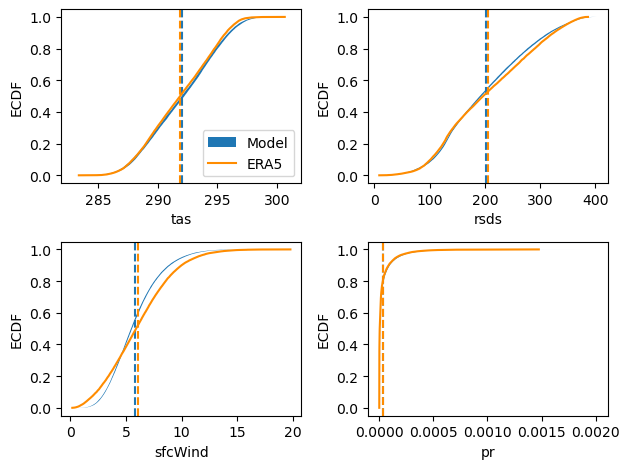

In [21]:
fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # ECDFs
    ecdf_era = ECDF(cell_era)
    ecdf_model = compute_ecdf_model(cell_model)
    
    p = plot_ecdfs(ax.flatten()[i], ecdf_era, ecdf_model, var)
    
    if i == 0:
        p.legend(loc="lower right")
    
    plt.tight_layout()

### Remove bias

In [21]:
def get_clim(ds, period, dim="time"):
    """
    Return the climatology over a period of time
    """
    return ds.groupby(f'{dim}.{period}').mean(dim)

In [45]:
def rolling(ds, k, first_year, last_year, dim="time"):
    """
    Return rolling k-day mean and don't select first year
    """
    ds_roll = ds.rolling({dim: k}).mean()
    return ds_roll.sel({dim: slice(str(first_year + 1), str(last_year))})

In [22]:
def get_bias(sim, obs, period, pool_members, method="additive", dim="time"):
    """
    Return the forecast bias over a period
    """
    if pool_members:
        sim_clim = get_clim(sim, period, dim).mean("member")
    else:
        sim_clim = get_clim(sim, period, dim)
        
    obs_clim = get_clim(obs, period, dim)
        
    if method == "additive":
        bias = sim_clim - obs_clim
    elif method == "multiplicative":
        bias = sim_clim / obs_clim
    else: 
        raise ValueError("Unrecognised method")
    return bias

In [23]:
def remove_bias(sim, bias, period, method="additive", dim="time"):
    """
    Remove the bias
    """
    if method == "additive":
        return (sim.groupby(f'{dim}.{period}') - bias).drop(period)
    elif method == "multiplicative":
        return (sim.groupby(f'{dim}.{period}') / bias).drop(period)
    else: 
        raise ValueError("Unrecognised method")

In [31]:
def plot_clim(ax, clim_era, clim_model, var_name, period):
    """
    Plot climatology of ERA5 and 5-95th model clim.
    """
    ax.fill_between(clim_model[period], clim_model.quantile(0.05, "member"), clim_model.quantile(0.95, "member"), label="Model")
    ax.plot(clim_model[period], e_clim, c="darkorange", label="ERA5")

    ax.set_xlabel(period)
    ax.set_ylabel(var_name)
    
    return ax

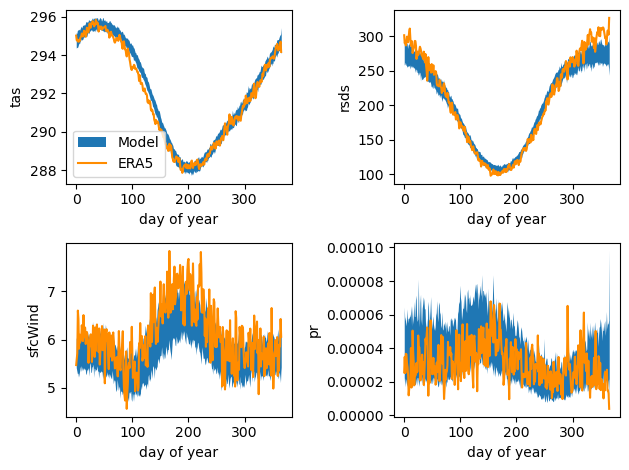

In [52]:
period = "dayofyear"

fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Climatology
    e_clim = get_clim(cell_era, period)
    m_clim = get_clim(cell_model, period)
    
    p = plot_clim(ax.flatten()[i], e_clim, m_clim, var, period)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

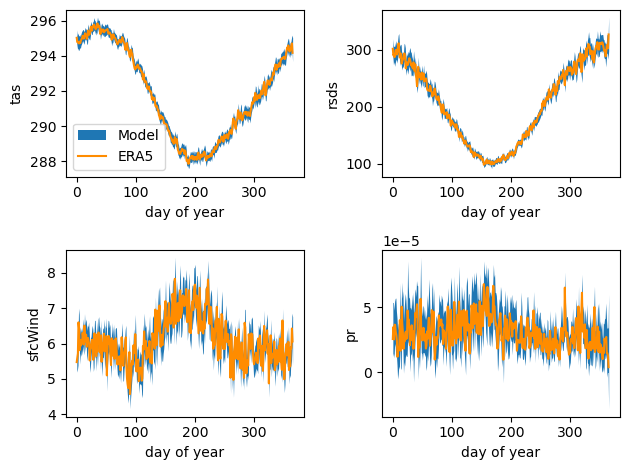

In [53]:
period = "dayofyear"

fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Remove bias
    if var == "tas":
        method = "additive"
    else:
        method == "multiplicative"
        
    m_bc = remove_bias(
        cell_model,
        get_bias(cell_model, cell_era, period, True, method),
        period,
        method
    )
    
    # climatology
    m_bc_clim = get_clim(m_bc, period)
    e_clim = get_clim(cell_era, period)
    
    p = plot_clim(ax.flatten()[i], e_clim, m_bc_clim, var, period)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

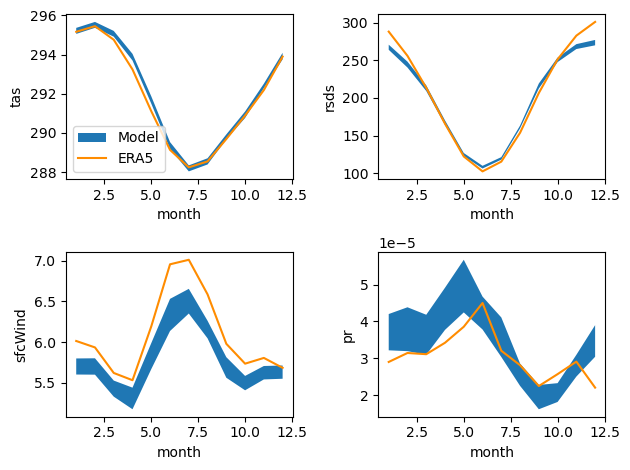

In [37]:
period = "month"

fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Climatology
    e_clim = get_clim(cell_era, period)
    m_clim = get_clim(cell_model, period)
    
    p = plot_clim(ax.flatten()[i], e_clim, m_clim, var, period)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

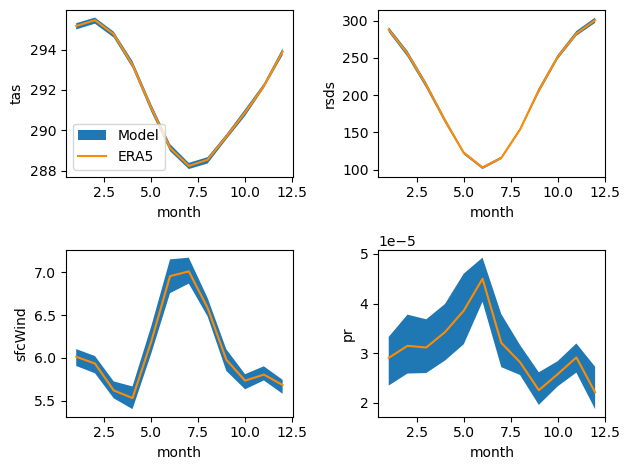

In [33]:
period = "month"

fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Remove bias
    if var == "tas":
        method = "additive"
    else:
        method == "multiplicative"
        
    m_bc = remove_bias(
        cell_model,
        get_bias(cell_model, cell_era, period, True, method),
        period,
        method
    )
    
    # climatology
    m_bc_clim = get_clim(m_bc, period)
    e_clim = get_clim(cell_era, period)
    
    p = plot_clim(ax.flatten()[i], e_clim, m_bc_clim, var, period)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

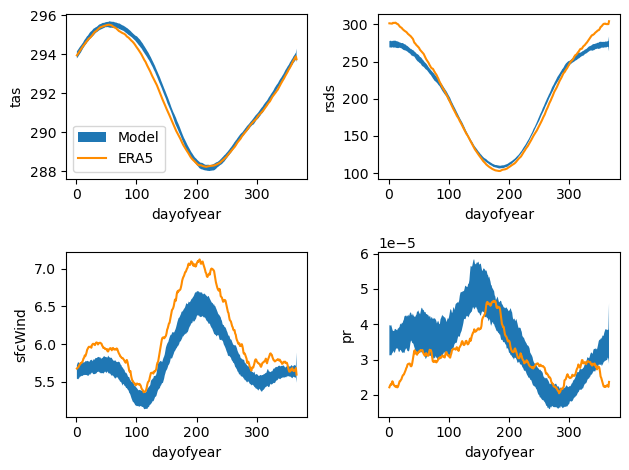

In [48]:
period = "dayofyear"

fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Rolling means
    r_era = rolling(cell_era, 31, 1959, 2014)
    r_model = rolling(cell_model, 31, 1959, 2014)
    
    # Climatology
    e_clim = get_clim(r_era, period)
    m_clim = get_clim(r_model, period)
    
    p = plot_clim(ax.flatten()[i], e_clim, m_clim, var, period)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

# Note on climatology period:

I have tried removing a dayofyear, rolling 31-day dayofyear and monthly climatology. Dayof year is too noisy - maybe appropriate when computing anomalies of the same dataset, but not when removing bias in climate models. 31-day dayofyear is complicated because it doesn't work too well for leap year days. Monthly is best then, despite the jump for each month not being too appropriate for the end and start of two consecutive months.

### But when should we bias correct? For all cases where model != obs? Or only when model is substantially different?

In [98]:
from scipy.stats import kstest, ttest_ind

In [124]:
cell_era = sel_cell(tas_era, cell).compute()
cell_model = sel_cell(tas_model, cell).compute()

In [133]:
month = 1

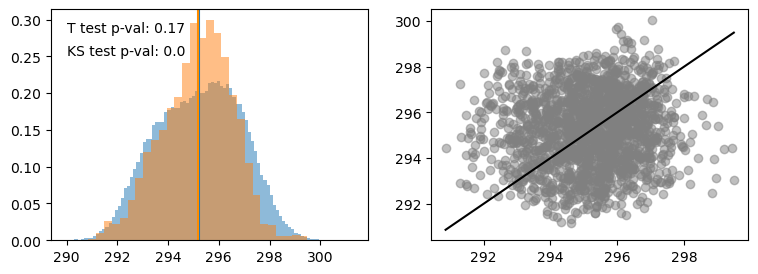

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))

m = cell_model.isel(time=cell_model.time.dt.month == month).values.flatten()
e = cell_era.isel(time=cell_era.time.dt.month == month).values

tp = np.round(ttest_ind(m[:len(e)], e)[1], 2)
ksp = np.round(kstest(m[:len(e)], e)[1], 2)

_ = ax[0].hist(m, "fd", density=True, alpha=0.5)
_ = ax[0].hist(e, 'fd', density=True, alpha=0.5)

ax[0].text(0.05, 0.9, "T test p-val: " + str(tp), transform=ax[0].transAxes)
ax[0].text(0.05, 0.8, "KS test p-val: " + str(ksp), transform=ax[0].transAxes)

ax[0].axvline(np.mean(m))
ax[0].axvline(np.mean(e), color="darkorange")

ax[1].scatter(e, m[:len(e)], alpha=0.5, color="gray")
ax[1].plot((np.min(e), np.max(e)), (np.min(e), np.max(e)), color="k")

### Bias correct all grid cells

In [34]:
bias = get_bias(tas_model, tas_era, "month", True, "additive")

m_bc = remove_bias(
    tas_model,
    bias,
    "month",
    "additive"
)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 56 times more chunks
  return self.array[key]


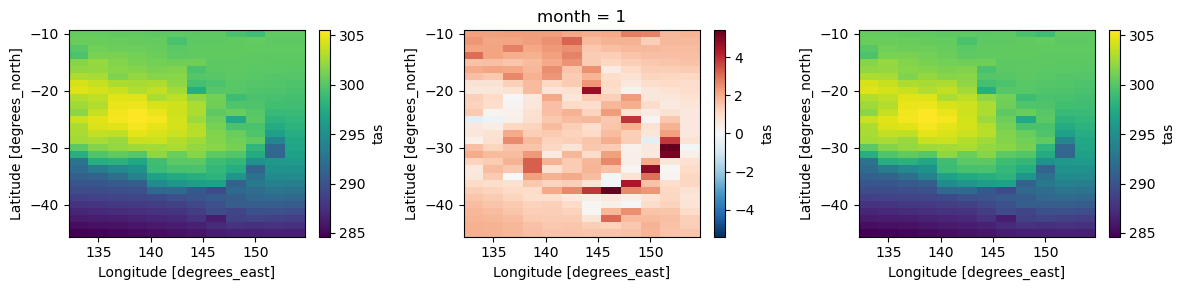

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

tas_era.isel(time=tas_era.time.dt.month==1).mean(["time"]).plot(ax=ax[0])
bias.sel(month=1).plot(ax=ax[1])
m_bc.isel(time=m_bc.time.dt.month==1).mean(["time", "member"]).plot(ax=ax[2])

plt.tight_layout()

In [104]:
m_bc

<xarray.DataArray 'tas' (member: 40, time: 20454, lat: 29, lon: 12)>
dask.array<sub, shape=(40, 20454, 29, 12), dtype=float32, chunksize=(5, 1, 29, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -45.0 -43.75 -42.5 -41.25 ... -12.5 -11.25 -10.0
  * lon      (lon) float64 133.1 135.0 136.9 138.8 ... 148.1 150.0 151.9 153.8
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) datetime64[ns] 1959-01-01T12:00:00 ... 2014-12-31T12:00:00